# Problem 1


In [1]:
library(quantmod)
library(rugarch)
library(ggplot2)
library(fGarch)
library(tseries)
library(forecast)

Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



################################### WARNING ###################################
# We noticed you have dplyr installed. The dplyr lag() function breaks how    #
# base R's lag() function is supposed to work, which breaks lag(my_xts).      #
#                                                                             #
# If you call library(dplyr) later in this session, then calls to lag(my_xts) #
# that you enter or source() into this session won't work correctly.          #
#                                                                             #
# All package code is unaffected because it is protected by the R namespace   #
# mechanism.                                                                  #
#                                                                             #
# Set `options(xts.warn

In [2]:
set.seed(32480239)


In [3]:
#symbols <- read.csv('C:/Users/Uzivatel/Documents/New_component/IES/2022_2023/Financial_econometrics_I/Homework2/symbols2.csv')
head(symbols)

,X,Symbol,Name,Sector
,<int>,<chr>,<chr>,<chr>
1,1,MMM,3M Co.,Industrials
2,2,ACE,ACE Limited,Financials
3,3,ABT,Abbott Laboratories,Health Care
4,4,ANF,Abercrombie & Fitch Company A,Consumer Discretionary
5,5,ACN,Accenture,Information Technology
6,6,ADBE,Adobe Systems Inc,Information Technology


In [4]:
# Generate 100 random integers between 1 and 377
random_nums <- sample(1:377, 100)

# Select Tickers from rows with indices equal to the random numbers generated
tickers <- symbols[random_nums, "Symbol"]
# Download stock prices for tickers for the period 07/2019 - 07/2022
start_date <- as.Date("2019-06-28")
end_date <- as.Date("2022-07-01")

prices <- lapply(tickers, function(ticker) {
  tryCatch(
    # Try to download the stock prices using quantmod package
    getSymbols(ticker, from = start_date, to = end_date, auto.assign = FALSE),
    error = function(e) {
      # If there is an error, return NULL instead of the prices
      NULL
    }
  )
})

Warning message:
"PBCT download failed; trying again."
Warning message:
"BHI download failed; trying again."
Warning message:
"DISCA download failed; trying again."
Warning message:
"BMS download failed; trying again."


In [5]:
# Remove NULL elements from prices list (i.e. tickers that weren't found in quantmod)
prices <- prices[!sapply(prices, is.null)]

# Extract the Close prices of each stock and combine into a single data frame
prices_df <- do.call(merge, lapply(prices, Cl))

# Get the tickers that were successfully downloaded
downloaded_tickers <- names(prices)

# Remove the ".Close" suffix from the downloaded tickers
downloaded_tickers <- gsub("\\.Close", "", downloaded_tickers)

# Set the column names of the data frame to the downloaded ticker names without the ".Close" suffix
colnames(prices_df) <- downloaded_tickers

### Problem 1.1

In [6]:
log_returns<- diff(log(prices_df))
log_returns<-na.omit(log_returns)

### Problem 1.2

In [7]:
# Set the specification for the GARCH(1,1) model
spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)), 
                   mean.model = list(armaOrder = c(0,0), include.mean = TRUE), 
                   distribution.model = "norm")

# Estimate the parameters of the GARCH(1,1) model for each stock
garch_models <- lapply(prices_df, function(x) {
  tryCatch(
    # Try to estimate the GARCH(1,1) model
    ugarchfit(spec = spec, data = x, solver = "hybrid"),
    error = function(e) {
      # If there is an error, return NULL instead of the model
      NULL
    }
  )
})


In [8]:
# Remove NULL elements from garch_models list (i.e. stocks for which the model could not be estimated)
garch_models <- garch_models[!sapply(garch_models, is.null)]

### Problem 1.3

In [9]:
# Extract alpha1, beta1, and alpha1+beta1 coefficients from each model
alpha1 <- sapply(garch_models, function(model) coef(model)["alpha1"])
beta1 <- sapply(garch_models, function(model) coef(model)["beta1"])
alpha1_beta1 <- alpha1 + beta1

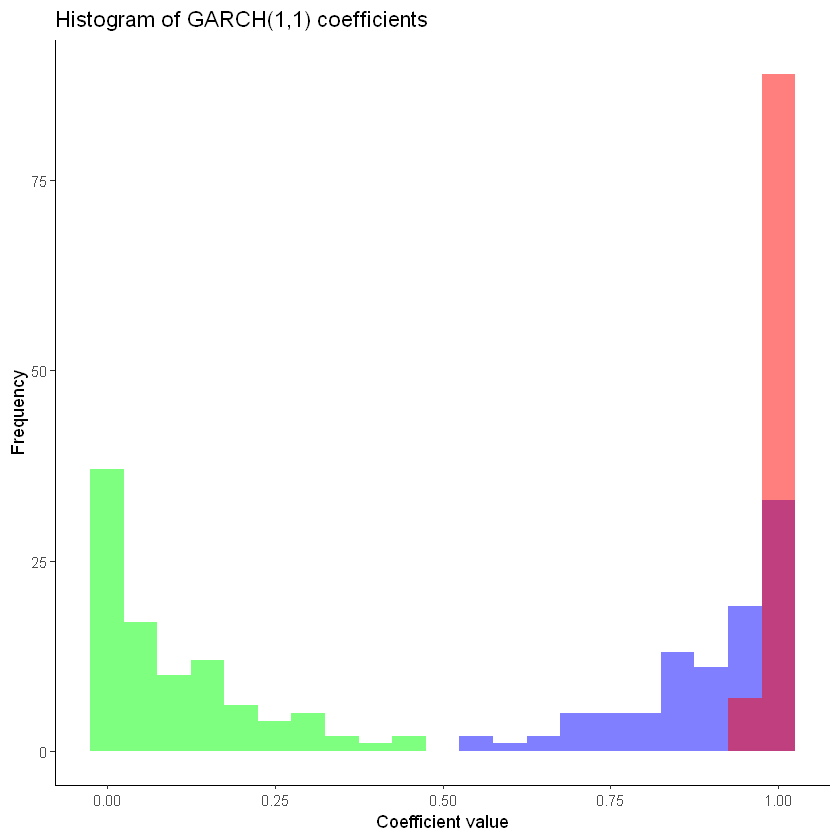

In [10]:
# Combine coefficients into a data frame
coeff_df <- data.frame(alpha1, beta1, alpha1_beta1)

# Plot histograms of coefficients
ggplot(data = coeff_df) +
  geom_histogram(aes(x = alpha1), binwidth = 0.05, fill = "blue", alpha = 0.5) +
  geom_histogram(aes(x = beta1), binwidth = 0.05, fill = "green", alpha = 0.5) +
  geom_histogram(aes(x = alpha1_beta1), binwidth = 0.05, fill = "red", alpha = 0.5) +
  xlab("Coefficient value") +
  ylab("Frequency") +
  ggtitle("Histogram of GARCH(1,1) coefficients") +
  theme_classic()

### Problem 1.4

In [11]:
# Find minimum and maximum values
min_alpha1 <- min(alpha1)
max_alpha1 <- max(alpha1)

min_beta1 <- min(beta1)
max_beta1 <- max(beta1)

min_alpha1_plus_beta1 <- min(alpha1_plus_beta1)
max_alpha1_plus_beta1 <- max(alpha1_plus_beta1)

In [12]:
print(min_alpha1)
print(max_alpha1)

print(min_beta1)
print(max_beta1)

print(min_alpha1_plus_beta1)
print(max_alpha1_plus_beta1)

[1] 0.5675347
[1] 0.9989999
[1] 1.237547e-09
[1] 0.4314652
[1] 0.9632815
[1] 0.999


### Problem 1.5

In [ ]:
# Calculate daily GARCH volatility for cross-section of 96 stocks
volatility <- apply(log_returns, 1, function(x) {
  model <- garchFit(formula = ~ garch(1,1), data = x, trace = F)
  predict(model, n.ahead = 1)$standardDeviation
})

# Obtain median and quantiles of market volatility
volatility_median <- median(volatility)
volatility_5quantile <- quantile(volatility, 0.05)
volatility_95quantile <- quantile(volatility, 0.95)

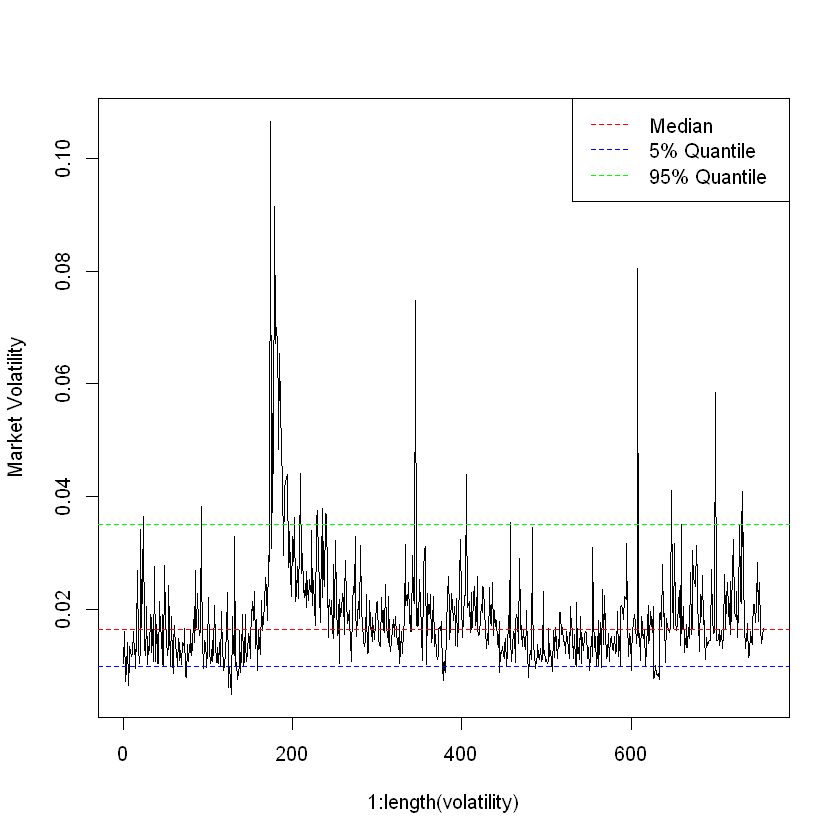

In [14]:
# Create figure of median and quantiles of market volatility
plot(1:length(volatility), volatility, type = "l", ylab = "Market Volatility")
abline(h = volatility_median, col = "red", lty = 2)
abline(h = volatility_5quantile, col = "blue", lty = 2)
abline(h = volatility_95quantile, col = "green", lty = 2)
legend("topright", legend = c("Median", "5% Quantile", "95% Quantile"), col = c("red", "blue", "green"), lty = 2)


# Problem 2

[1] 757

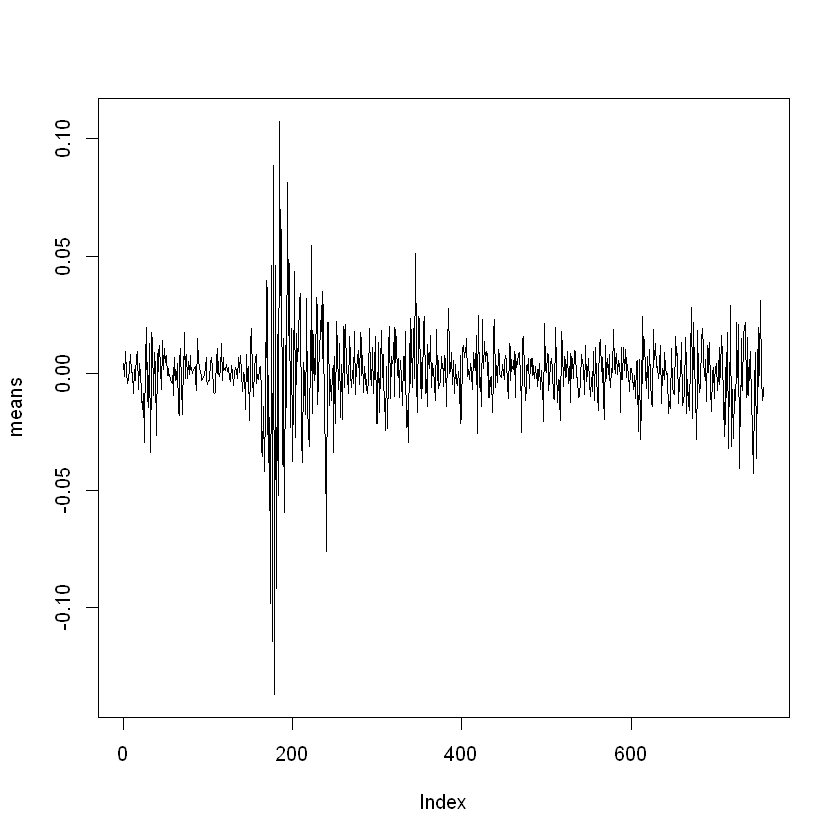

In [15]:
dim(log_returns)[1]
T <- dim(log_returns)[1]
means <- sapply(1:T, function(y){
  mean(sapply(log_returns, '[[', y)) 
})
plot(means, type = 'l')

In [16]:
#test for stationarity
adf.test(means)

Warning message in adf.test(means):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  means
Dickey-Fuller = -7.7259, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


We can reject non-stationarity at 1% level. Therefore series is very likely stationary.

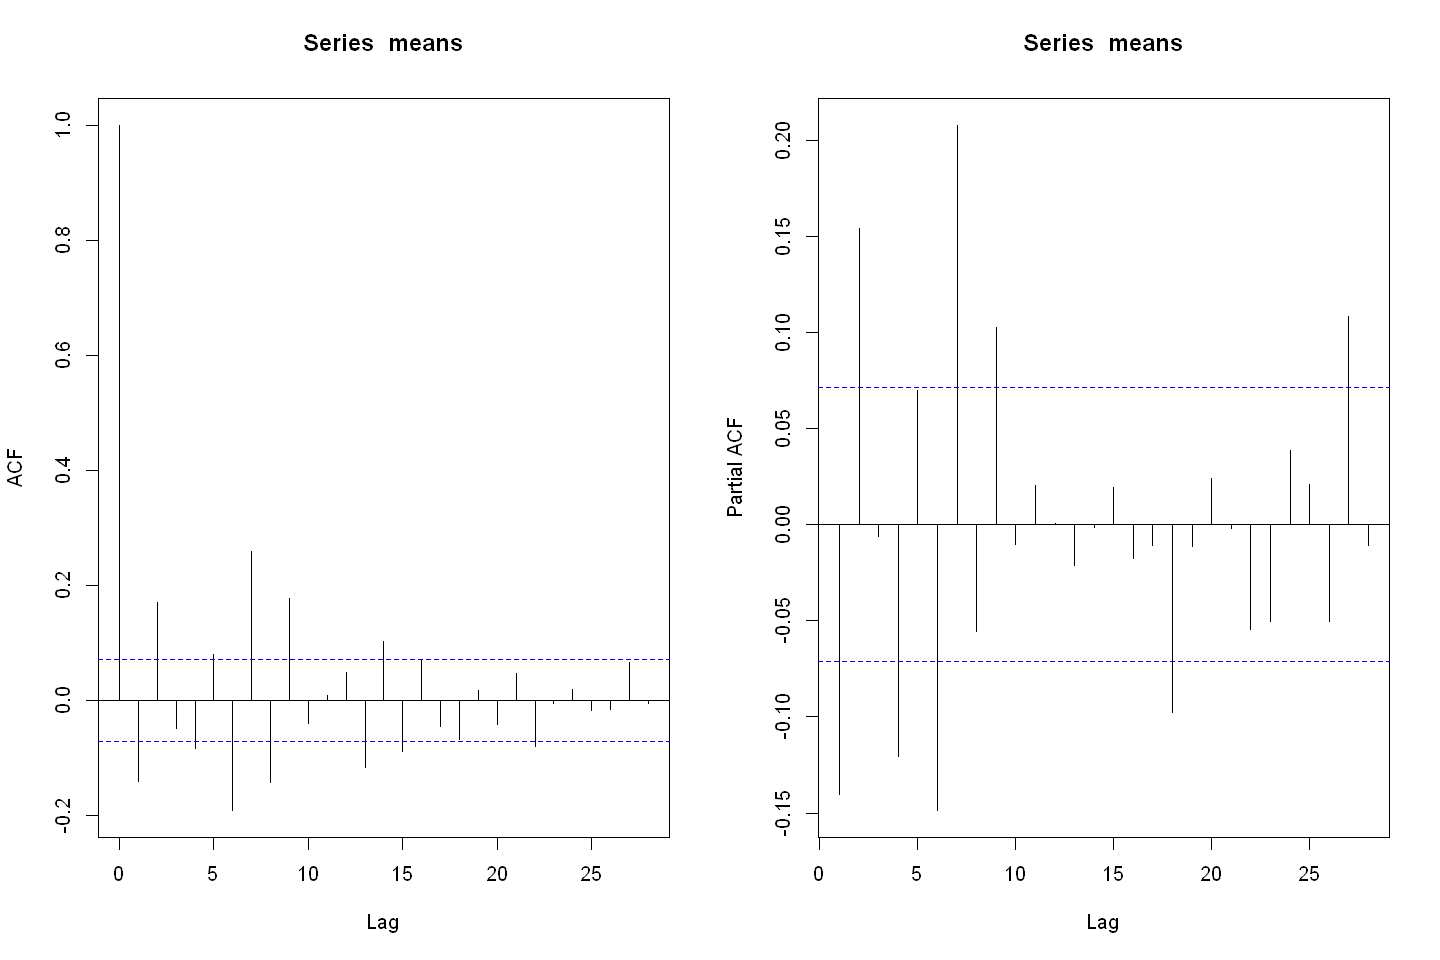

In [17]:
options(repr.plot.width=12, repr.plot.height=8)
par(mfrow = c(1, 2))
acf(means)
pacf(means)

After considering autocorrelation function and partial autocorrelation function we choose ARMA(1,2), ARMA(2,2), ARMA(4,2) and ARMA(2,4). In both, PACF and ACF, even lags of higher orders are significant, however the corresponding models would be very complicated, what is against idea of parsimony. We can check the models of higher orders if none of our four models would be appropriate.

For easier manipulation we call these models ARMA1, ARMA2, ARMA3 and ARMA4.

In [18]:
ARMA1 <- Arima(means, order = c(1, 0, 2))
summary(ARMA1)
ARMA2 <- Arima(means, order = c(2, 0, 2))
summary(ARMA2)
ARMA3 <- Arima(means, order = c(4, 0, 2))
summary(ARMA3)
ARMA4 <- Arima(means, order = c(2, 0, 4))
summary(ARMA4)

Series: means 
ARIMA(1,0,2) with non-zero mean 

Coefficients:
          ar1     ma1     ma2   mean
      -0.2705  0.1567  0.1600  2e-04
s.e.   0.1542  0.1524  0.0405  6e-04

sigma^2 = 0.000288:  log likelihood = 2013.58
AIC=-4017.16   AICc=-4017.08   BIC=-3994.01

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 9.156938e-06 0.01692541 0.01084057 44.13534 180.6209 0.6891997
                    ACF1
Training set -0.00262106

Series: means 
ARIMA(2,0,2) with non-zero mean 

Coefficients:
          ar1      ar2     ma1     ma2   mean
      -1.7316  -0.8799  1.6048  0.7251  2e-04
s.e.   0.0329   0.0348  0.0461  0.0474  6e-04

sigma^2 = 0.0002712:  log likelihood = 2036.62
AIC=-4061.24   AICc=-4061.13   BIC=-4033.46

Training set error measures:
                     ME       RMSE        MAE      MPE     MAPE      MASE
Training set 1.4629e-07 0.01641369 0.01073787 101.7156 169.2772 0.6826706
                  ACF1
Training set 0.0808404

Series: means 
ARIMA(4,0,2) with non-zero mean 

Coefficients:
          ar1      ar2     ar3      ar4     ma1     ma2   mean
      -1.4674  -0.5111  0.1223  -0.0315  1.4228  0.5647  2e-04
s.e.   0.1127   0.1278  0.0681   0.0518  0.1072  0.1047  6e-04

sigma^2 = 0.0002677:  log likelihood = 2042.5
AIC=-4068.99   AICc=-4068.8   BIC=-4031.96

Training set error measures:
                        ME       RMSE        MAE      MPE     MAPE      MASE
Training set -1.101111e-08 0.01628582 0.01079321 98.09503 196.6061 0.6861893
                     ACF1
Training set 0.0001754987

Series: means 
ARIMA(2,0,4) with non-zero mean 

Coefficients:
          ar1      ar2     ma1     ma2     ma3      ma4   mean
      -1.6756  -0.8369  1.6335  0.8743  0.1082  -0.0197  2e-04
s.e.   0.0461   0.0466  0.0574  0.0823  0.0748   0.0453  6e-04

sigma^2 = 0.0002675:  log likelihood = 2042.71
AIC=-4069.41   AICc=-4069.22   BIC=-4032.38

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 1.950884e-06 0.01628115 0.01078061 99.36849 196.5483 0.6853882
                     ACF1
Training set -0.000988103

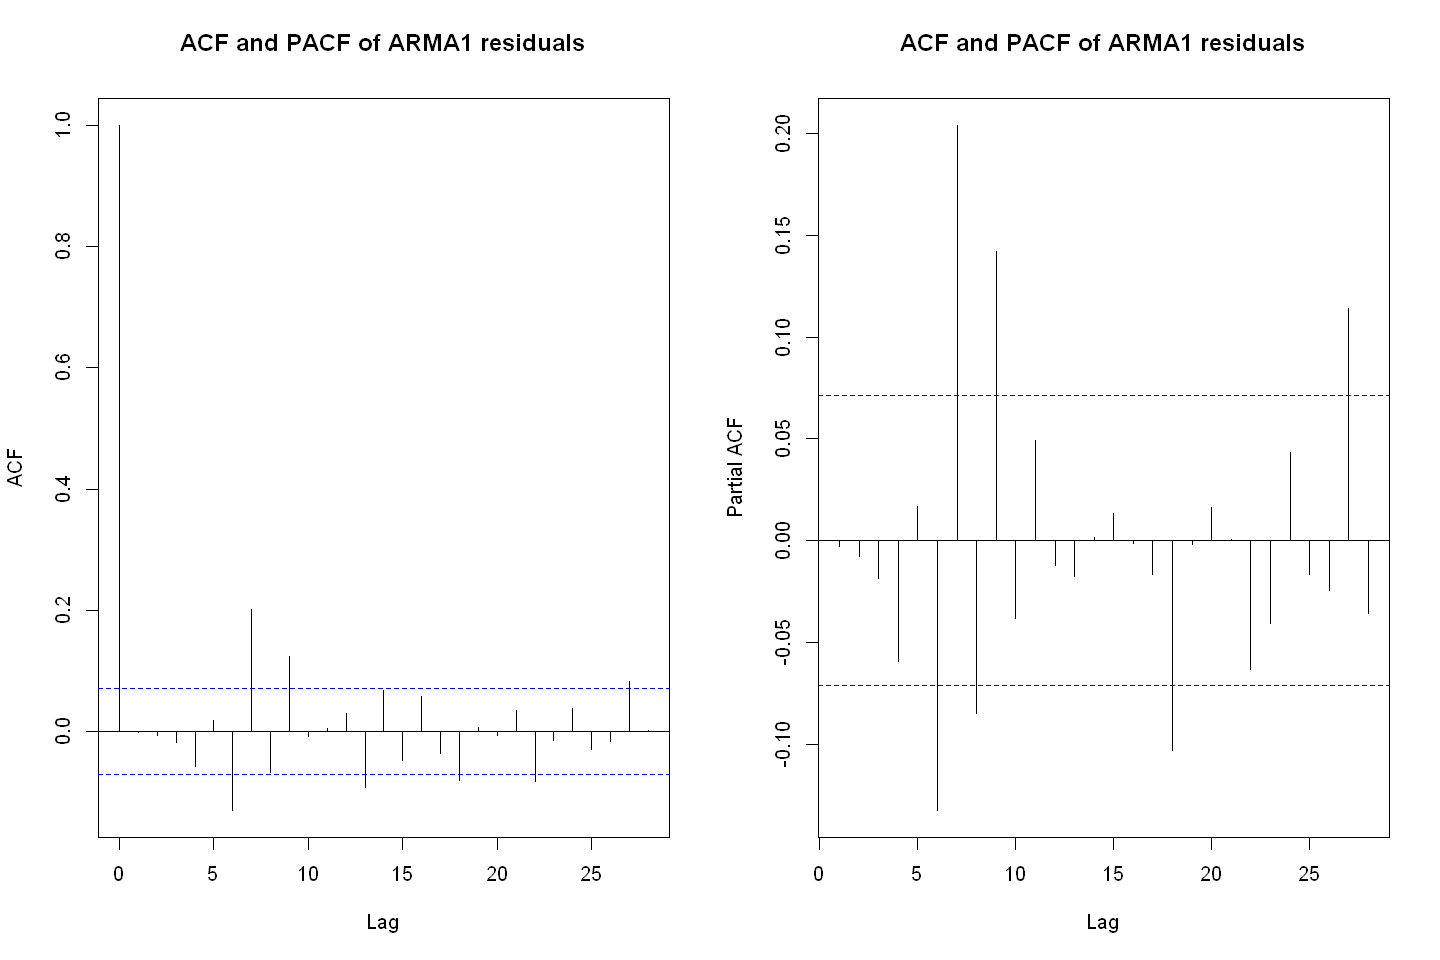

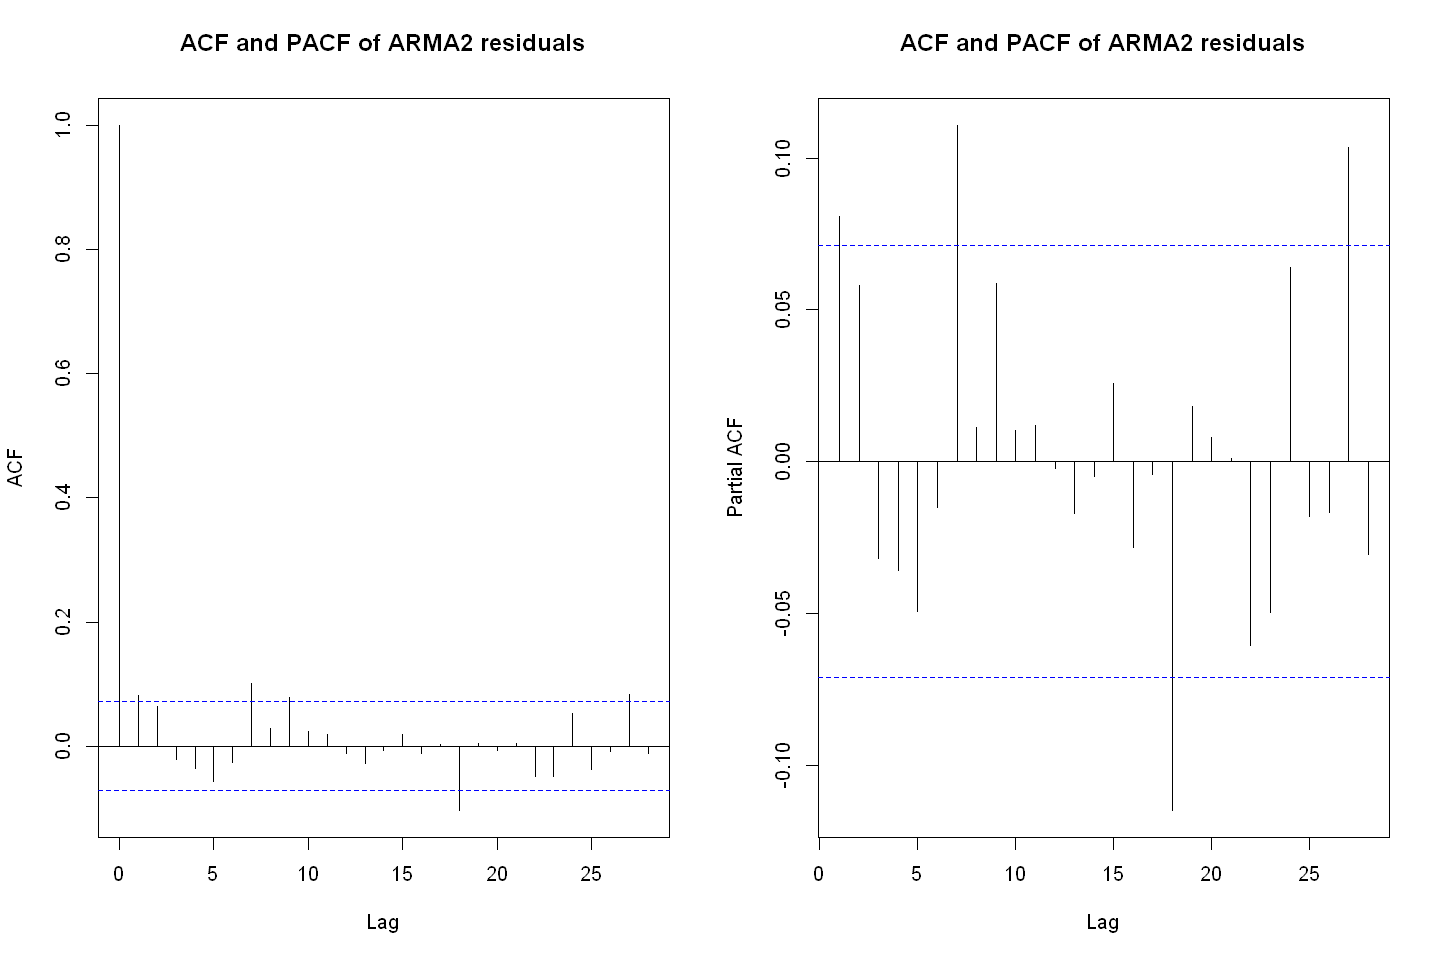

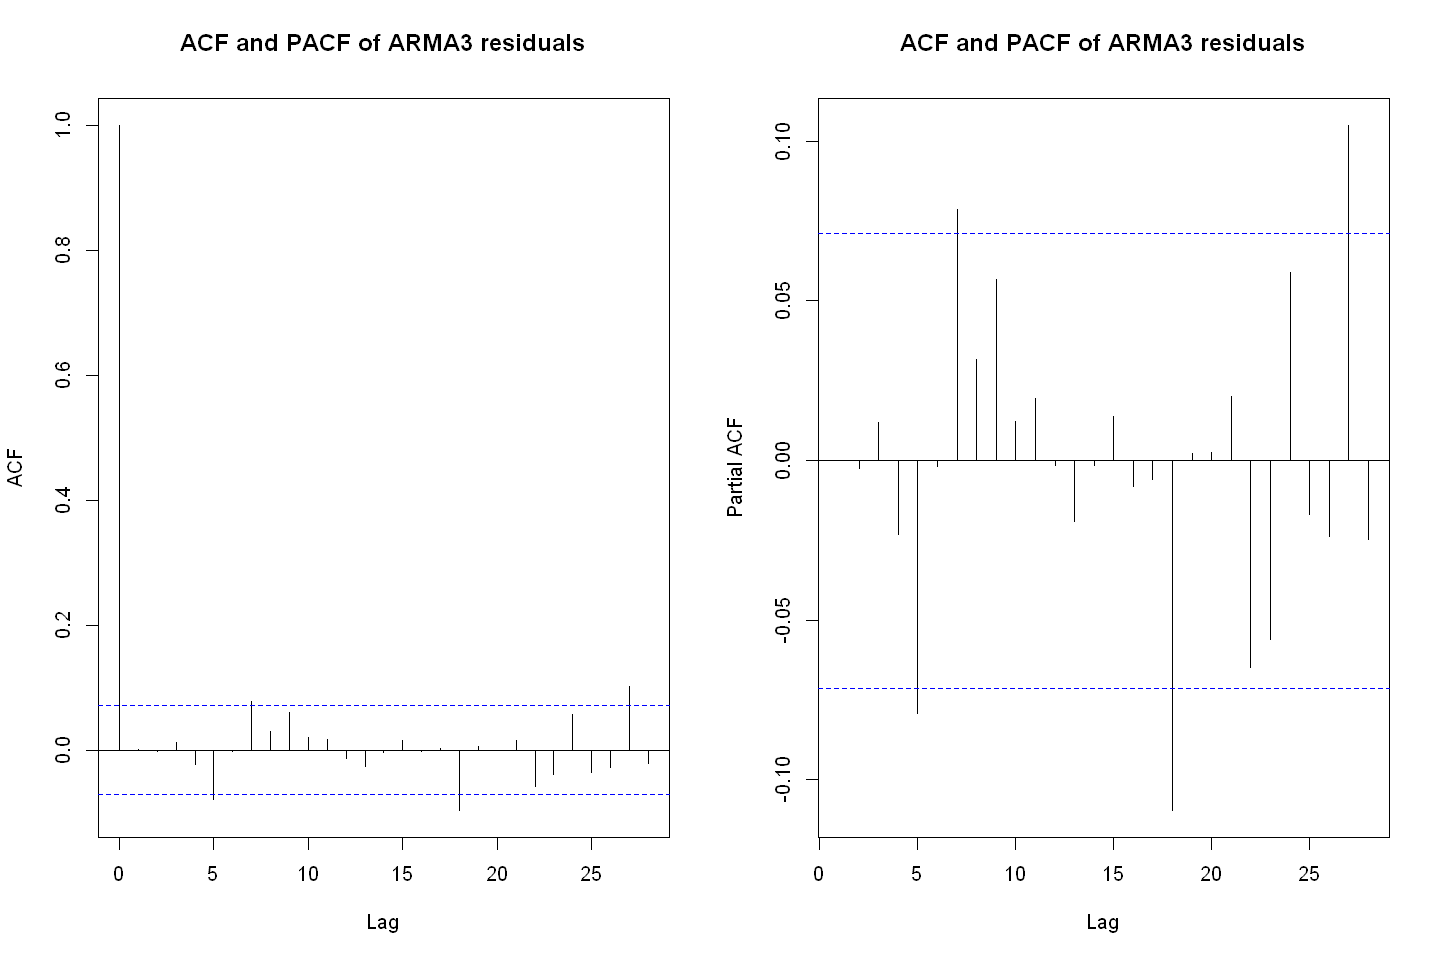

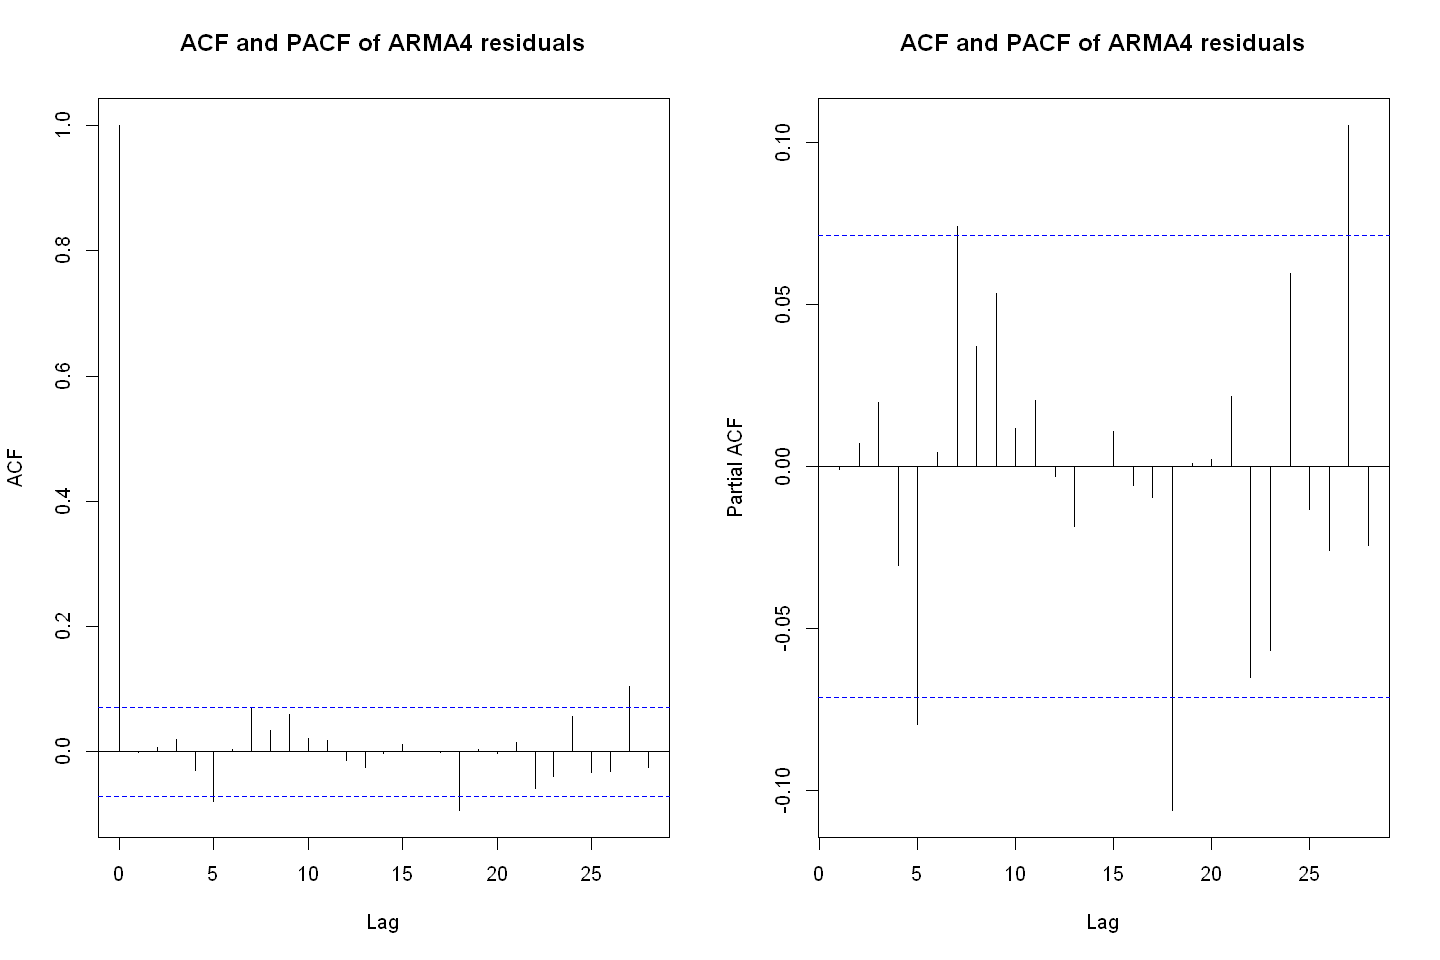

In [19]:
par(mfrow = c(1,2))
for (i in 1:4) {
  model <- get(paste0("ARMA", i))
  plot_title <- paste0("ACF and PACF of ", paste0("ARMA", i, " residuals"))
  acf(model$residuals, main = plot_title)
  pacf(model$residuals, main = plot_title)
}

In ACF and PACF of residuals there are no significant lags of orders lower than 5. However we should rule out AMRA(1,2) since there are considerbaly more significant lags than for other three models. For ARMA(2,2), ARMA(4,2) and ARMA(2,4) most of the lags became insignificant or are slightly above the treshold.

In [20]:
for (i in 1:4) {
    model <- get(paste0("ARMA", i))
    print(paste0("ARMA", i))
    print(Box.test(model$residuals, type = "Ljung-Box", lag = 4))
    print(Box.test(model$residuals, type = "Ljung-Box", lag = 8))
    print(Box.test(model$residuals, type = "Ljung-Box", lag = 12))
}

[1] "ARMA1"

	Box-Ljung test

data:  model$residuals
X-squared = 2.9522, df = 4, p-value = 0.5659


	Box-Ljung test

data:  model$residuals
X-squared = 51.009, df = 8, p-value = 2.614e-08


	Box-Ljung test

data:  model$residuals
X-squared = 63.4, df = 12, p-value = 5.379e-09

[1] "ARMA2"

	Box-Ljung test

data:  model$residuals
X-squared = 9.4453, df = 4, p-value = 0.05088


	Box-Ljung test

data:  model$residuals
X-squared = 20.923, df = 8, p-value = 0.007354


	Box-Ljung test

data:  model$residuals
X-squared = 26.422, df = 12, p-value = 0.009351

[1] "ARMA3"

	Box-Ljung test

data:  model$residuals
X-squared = 0.52234, df = 4, p-value = 0.9713


	Box-Ljung test

data:  model$residuals
X-squared = 10.652, df = 8, p-value = 0.2222


	Box-Ljung test

data:  model$residuals
X-squared = 14.041, df = 12, p-value = 0.2981

[1] "ARMA4"

	Box-Ljung test

data:  model$residuals
X-squared = 1.0463, df = 4, p-value = 0.9027


	Box-Ljung test

data:  model$residuals
X-squared = 10.61, df = 8, p

The null hypothesis is joint insignificance of autocorrelation coefficients 1 to 4, 8, or 12. We reject join insignificance except for the cases of 8 and 12 lags for ARMA(1,2) and ARMA(2,2)

Now we obtain AIC and BIC for all four models.

In [21]:
models <- 4
criteria <- matrix(ncol = 2, nrow = models)
colnames(criteria) <- c('AIC', 'BIC')
rownames(criteria) <- c('ARMA1', 'ARMA2','ARMA3','ARMA4')
  
criteria[1, 1] <- ARMA1$aic
criteria[1, 2] <- ARMA1$bic
criteria[2, 1] <- ARMA2$aic
criteria[2, 2] <- ARMA2$bic
criteria[3, 1] <- ARMA3$aic
criteria[3, 2] <- ARMA3$bic
criteria[4, 1] <- ARMA4$aic
criteria[4, 2] <- ARMA4$bic
rownames(criteria)<-c("ARMA(1,2)", "ARMA(2,2)", "ARMA(4,2)", "ARMA(2,4)")
criteria

,AIC,BIC
"ARMA(1,2)",-4017.157,-3994.010
"ARMA(2,2)",-4061.241,-4033.464
"ARMA(4,2)",-4068.993,-4031.959
"ARMA(2,4)",-4069.412,-4032.377


We can notice that ARMA(1,2) is by far the worst and there are only small differences between the three models.
Other results are ambiguous. According to AIC we would choose ARMA(2,4), while with BIC ARMA(2,2). Recall that for ARMA(2,2) there was still unremoved depndence in the lags as we can see in results of Ljung-Box tests. However we should prefer parsimony, especially when the AIC and BIC values are so similar. Thus we would choose ARMA(2,2).

In [22]:
auto.arima(means, ic = "aic")
auto.arima(means, ic = "bic")

Series: means 
ARIMA(2,0,4) with zero mean 

Coefficients:
          ar1      ar2     ma1     ma2     ma3      ma4
      -1.6753  -0.8366  1.6334  0.8745  0.1088  -0.0194
s.e.   0.0462   0.0466  0.0575  0.0824  0.0748   0.0453

sigma^2 = 0.0002672:  log likelihood = 2042.67
AIC=-4071.33   AICc=-4071.18   BIC=-4038.93

Series: means 
ARIMA(2,0,2) with zero mean 

Coefficients:
          ar1      ar2     ma1     ma2
      -1.7316  -0.8799  1.6050  0.7251
s.e.   0.0329   0.0348  0.0461  0.0473

sigma^2 = 0.0002709:  log likelihood = 2036.57
AIC=-4063.14   AICc=-4063.06   BIC=-4039.99

We can check that auto.arima function chooses the same model according to AIC and BIC. 

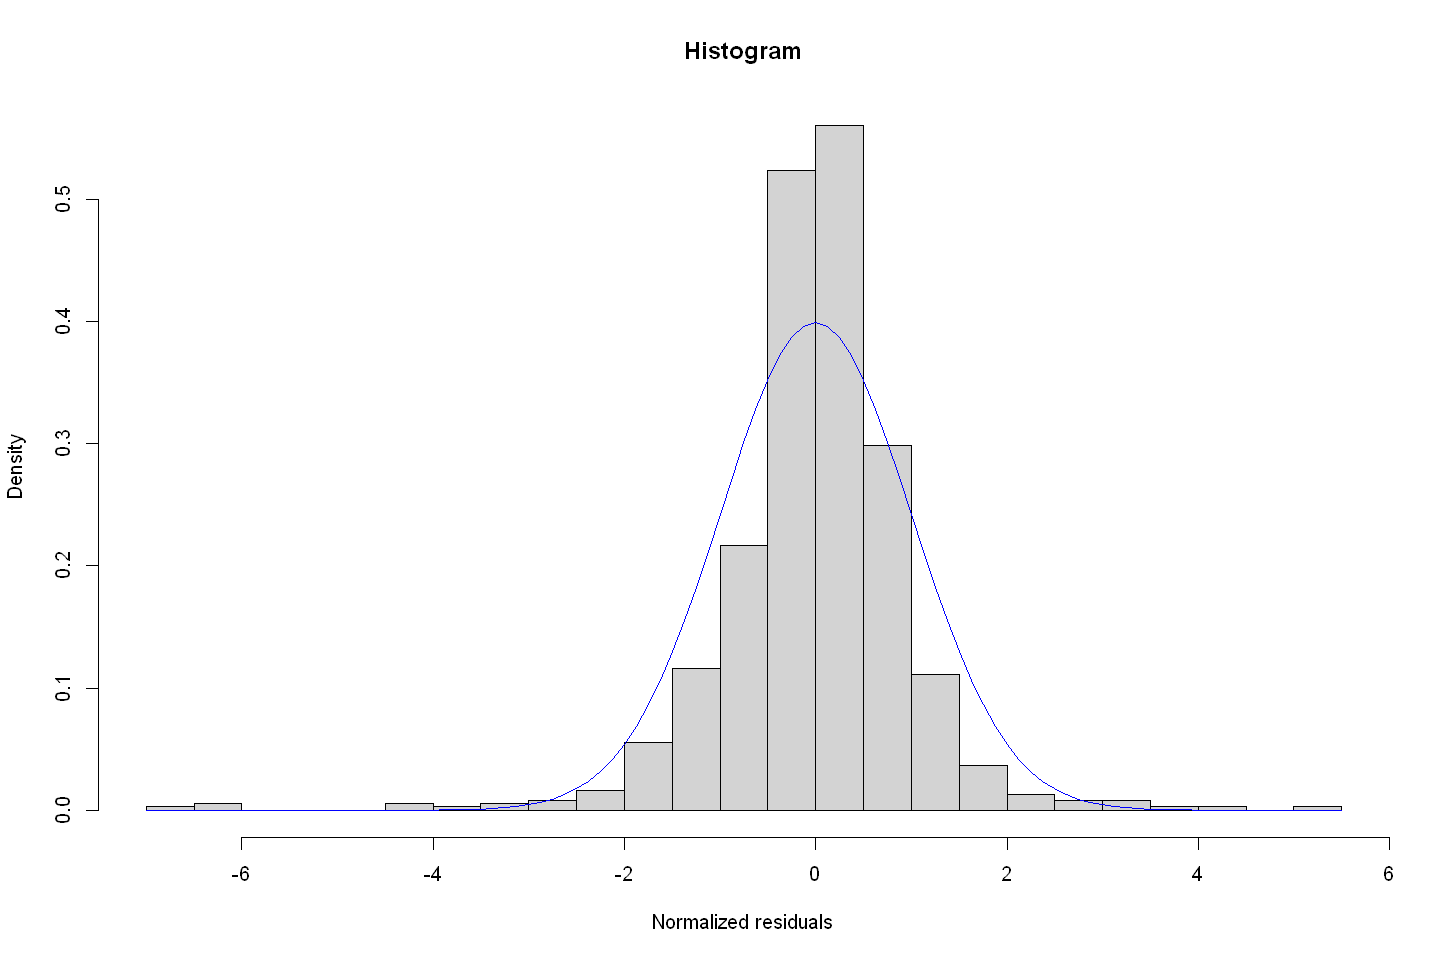

In [23]:
 residuals2 <- ARMA2$residuals
#normalize residuals 
    residuals2.norm <- residuals2/sqrt(ARMA2$sigma2)
#Plot the histogram
    hist(residuals2.norm, prob = TRUE, breaks=40, xlab = "Normalized residuals", main="Histogram")
    curve(dnorm(x, mean = 0, sd = 1), col="blue", lwd=1, add=TRUE)

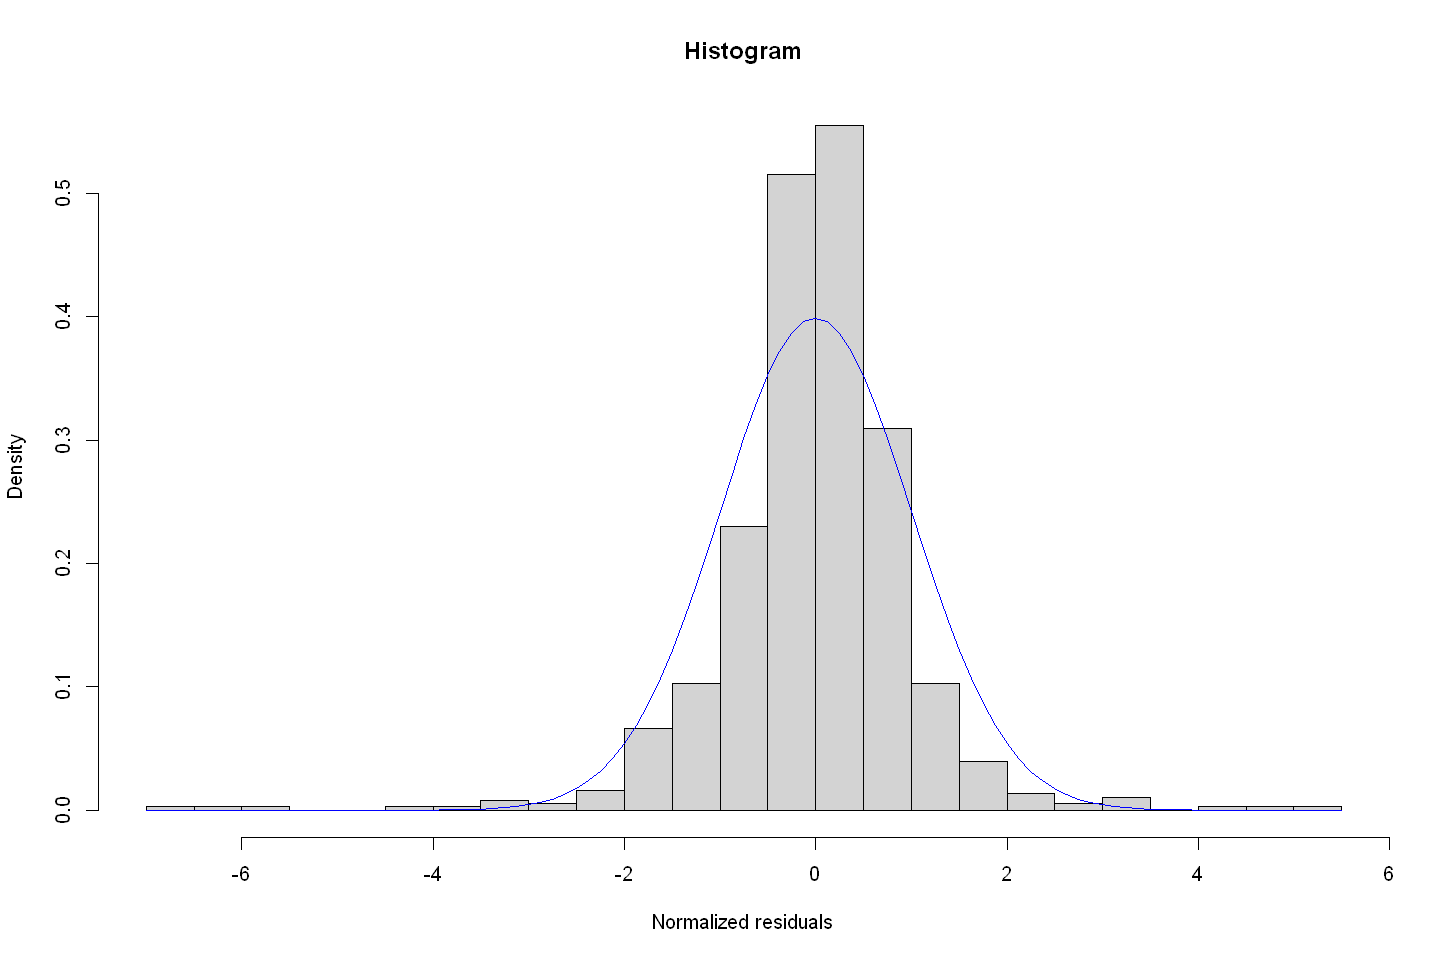

In [24]:
residuals4 <- ARMA4$residuals
#normalize residuals 
    residuals4.norm <- residuals4/sqrt(ARMA4$sigma2)
#Plot the histogram
    hist(residuals4.norm, prob = TRUE, breaks=40, xlab = "Normalized residuals", main="Histogram")
    curve(dnorm(x, mean = 0, sd = 1), col="blue", lwd=1, add=TRUE)

The residuals of both models are not exactly normally distributed. Thus there should be ways how to improve our models, however it might require different tools than ARMA.